# Group 21 Member: Robin, Fang Chong, Wenjing, Jing Chun, Sheng Yang

## **Problem Statement:** Singapore has a low recycling rate and items that are thrown into the blue recycling bin are only recyclable 50% of the time. The rubbish has to go to recycling sorting facilities and pass through conveyor belt lines and be physically sorted.

Source: https://www.channelnewsasia.com/singapore/in-focus-singapore-recycling-sustainability-blue-bins-waste-1339091

To tackle this. we consider image classification in recycling for blue bins by using some sort of image recognition capacity to allow user to ask if the item is recyclable and or what bins should the object be disposed in.

Kaggle Dataset:
https://www.kaggle.com/datasets/pengrin/recyclability
https://www.kaggle.com/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects
________________________________________________________________________
Methods:
Convolutional Neural Network

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install --upgrade kagglehub
!pip install tensorflow --upgrade
!pip install tensorflow-io
!pip install --upgrade tensorflow-io
!pip install --upgrade imbalanced-learn

import kagglehub

# Download latest version
path = kagglehub.dataset_download("pengrin/recyclability")
path2 = kagglehub.dataset_download("ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects")


print("Path to dataset files:")
print("Recyclability-dataset", path)
print("2nd recyclability dataset", path2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.9 MB/s eta 0:00:00


100%|██████████| 3.31G/3.31G [00:42<00:00, 83.7MB/s]

Extracting files...


100%|██████████| 66.7M/66.7M [00:00<00:00, 105MB/s]

Extracting files...


Path to dataset files:
Recyclability-dataset /root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3
2nd recyclability dataset /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2


In [ ]:
#import all modules neccessarily for image classification
import joblib
import random
from joblib import Parallel, delayed
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from PIL import Image
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from tqdm import tqdm
from IPython.display import YouTubeVideo
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


# **Waste Segregation Image Set**

---



In [ ]:
  # Define root directories (pointing to final_dataset folders)
base_dirs = [
    "/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/non_recyclable/final_dataset",
    "/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/recyclable/final_dataset",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/CAN",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/JUICE_BOX",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/MILK_CARTON",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/STYROFOAM",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/UTENSIL"
]


bad_img_list = []

# Loop through the base directories and check files in final_dataset
for base_dir in base_dirs:
    for f in os.listdir(base_dir):  # List files in final_dataset (no subfolders)
        fpath = os.path.join(base_dir, f)
        try:
            img = plt.imread(fpath)  # Try loading the image
        except:
            print(f"Removing corrupted image: {fpath}")
            bad_img_list.append(fpath)
            os.remove(fpath)  # Delete the corrupted image

print(f"Removed {len(bad_img_list)} corrupted images.")


Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (303).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (536).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (222).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (594).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (122).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main 

Only run the below cell block once per runtime due to the movement of images in the final_dataset folders to the train/test folders using shutil.move()

In [ ]:
# Define source directories for Pengrin and AshwinShrivastav datasets
pengrin_recyclable_dir = '/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/recyclable/final_dataset'
pengrin_non_recyclable_dir = '/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/non_recyclable/final_dataset'

ashwinshrivastav_recyclable_dirs = [
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/CAN'
]

ashwinshrivastav_non_recyclable_dirs = [
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/JUICE_BOX',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/MILK_CARTON',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/STYROFOAM',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/UTENSIL'
]

# Define destination directories for train/test splits
train_recyclable = '/root/.cache/kagglehub/datasets/reorganized/train/recyclable'
train_non_recyclable = '/root/.cache/kagglehub/datasets/reorganized/train/non_recyclable'
test_recyclable = '/root/.cache/kagglehub/datasets/reorganized/test/recyclable'
test_non_recyclable = '/root/.cache/kagglehub/datasets/reorganized/test/non_recyclable'

# Create necessary directories
os.makedirs(train_recyclable, exist_ok=True)
os.makedirs(train_non_recyclable, exist_ok=True)
os.makedirs(test_recyclable, exist_ok=True)
os.makedirs(test_non_recyclable, exist_ok=True)

# Helper function to move files into train/test splits
def split_and_move_images(source_dir, train_dir, test_dir, target_count=None):
    """
    Split images into train and test directories, ensuring an even distribution.

    Parameters:
    - source_dir: Directory of source images
    - train_dir: Destination directory for training images
    - test_dir: Destination directory for test images
    - target_count: If provided, limits the number of images to this count for balancing purposes
    """
    # Define allowed image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png']

    # Get list of image files with valid extensions
    images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)) and
              any(f.lower().endswith(ext) for ext in valid_extensions)]

    if len(images) == 0:
        print(f"No images found in {source_dir}. Skipping split for this directory.")
        return

    # If target_count is provided, limit the number of images for balancing
    if target_count is not None:
        # Ensure that target_count is not larger than the number of available images
        target_count = min(target_count, len(images))
        images = random.sample(images, target_count)

    # Split into train and test (80% train, 20% test)
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

    # Move the images to the appropriate directories
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Get the number of images in the recyclable directories (Pengrin and AshwinShrivastav)
pengrin_recyclable_images = [f for f in os.listdir(pengrin_recyclable_dir)
                             if os.path.isfile(os.path.join(pengrin_recyclable_dir, f)) and
                             any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])]

ashwinshrivastav_recyclable_images = []
for dir in ashwinshrivastav_recyclable_dirs:
    ashwinshrivastav_recyclable_images.extend([f for f in os.listdir(dir)
                                               if os.path.isfile(os.path.join(dir, f)) and
                                               any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])])

# Combine the recyclable images from both datasets
all_recyclable_images = pengrin_recyclable_images + ashwinshrivastav_recyclable_images

# Get the number of recyclable images
num_recyclable = len(all_recyclable_images)

# Get the number of images in the non-recyclable directories (Pengrin and AshwinShrivastav)
pengrin_non_recyclable_images = [f for f in os.listdir(pengrin_non_recyclable_dir)
                                 if os.path.isfile(os.path.join(pengrin_non_recyclable_dir, f)) and
                                 any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])]

ashwinshrivastav_non_recyclable_images = []
for dir in ashwinshrivastav_non_recyclable_dirs:
    ashwinshrivastav_non_recyclable_images.extend([f for f in os.listdir(dir)
                                                  if os.path.isfile(os.path.join(dir, f)) and
                                                  any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])])

# Combine the non-recyclable images from both datasets
all_non_recyclable_images = pengrin_non_recyclable_images + ashwinshrivastav_non_recyclable_images

# Get the number of non-recyclable images
num_non_recyclable = len(all_non_recyclable_images)

# Set the target size for recyclable images to be 1.3 times the size of non-recyclable
target_recyclable_count = int(num_non_recyclable * 1.3)

# Split and move images for recyclable (with target count for balancing) and non-recyclable
split_and_move_images(pengrin_recyclable_dir, train_recyclable, test_recyclable, target_count=target_recyclable_count)
split_and_move_images(ashwinshrivastav_recyclable_dirs[0], train_recyclable, test_recyclable, target_count=target_recyclable_count)
split_and_move_images(ashwinshrivastav_recyclable_dirs[1], train_recyclable, test_recyclable, target_count=target_recyclable_count)

split_and_move_images(pengrin_non_recyclable_dir, train_non_recyclable, test_non_recyclable)
for dir in ashwinshrivastav_non_recyclable_dirs:
    split_and_move_images(dir, train_non_recyclable, test_non_recyclable)

print("Dataset reorganized with reduced imbalance successfully!")


Dataset reorganized with reduced imbalance successfully!


In [ ]:
def verify_split(train_dir, test_dir):
    """
    Verifies the 80-20 split of files between train and test directories.

    Parameters:
        train_dir (str): Path to the training directory.
        test_dir (str): Path to the test directory.
    """
    # Count files in train and test directories
    train_files = sum([len(files) for _, _, files in os.walk(train_dir)])
    test_files = sum([len(files) for _, _, files in os.walk(test_dir)])

    # Calculate percentages
    total_files = train_files + test_files
    train_percentage = (train_files / total_files) * 100 if total_files > 0 else 0
    test_percentage = (test_files / total_files) * 100 if total_files > 0 else 0

    # Print results
    print(f"Train directory: {train_dir}, Files: {train_files}, Percentage: {train_percentage:.2f}%")
    print(f"test directory: {test_dir}, Files: {test_files}, Percentage: {test_percentage:.2f}%")
    print(f"Total files: {total_files}")
    print("\nSplit verified successfully" if 79.5 <= train_percentage <= 80.5 else "\nSplit verification failed")

# Verify for recyclable and non-recyclable categories
verify_split(train_recyclable, test_recyclable)
verify_split(train_non_recyclable, test_non_recyclable)

Train directory: /root/.cache/kagglehub/datasets/reorganized/train/recyclable, Files: 1870, Percentage: 79.98%
test directory: /root/.cache/kagglehub/datasets/reorganized/test/recyclable, Files: 468, Percentage: 20.02%
Total files: 2338

Split verified successfully
Train directory: /root/.cache/kagglehub/datasets/reorganized/train/non_recyclable, Files: 1482, Percentage: 79.89%
test directory: /root/.cache/kagglehub/datasets/reorganized/test/non_recyclable, Files: 373, Percentage: 20.11%
Total files: 1855

Split verified successfully


Due to high intra-class variability (e.g., items in recyclable/non recyclable look very different from one another), you might need more diverse examples to ensure the model generalizes well. Augmentation can help simulate diversity.

If this model is for real-world use, you need it to handle unexpected scenarios, such as:
Items that are partially recyclable (e.g., a pizza box with grease stains).
Variations in lighting, angles, or cluttered backgrounds.
Augmentation can help improve real-world robustness.

In [ ]:
def make_dataframes(train_dir, test_dir, bad_img_list):
    dirlist = [train_dir, test_dir]
    names = ['train', 'valid']
    zipdir = zip(names, dirlist)

    # Initialize the dataframes before loop
    pdf = None
    valid_df = None
    image_extensions = ['.jpg', '.jpeg', '.png']  # Valid image extensions

    for name, d in zipdir:
        print(f"Checking directory: {d}")  # Debug print to ensure correct directory
        filepaths = []
        labels = []

        try:
            major_classlist = sorted(os.listdir(d))
            print(f"Found {len(major_classlist)} major classes in {d}")
        except FileNotFoundError:
            print(f"Directory {d} not found. Please check the path.")
            continue

        for major_class in major_classlist:
            major_classpath = os.path.join(d, major_class)
            if not os.path.isdir(major_classpath):  # Skip if it's not a directory
                continue

            # Check files in the major class folder directly (not expecting nested subfolders)
            flist = sorted(os.listdir(major_classpath))
            for f in tqdm(flist, ncols=130, desc=f'{name:5s}-{major_class:25s}', unit='files', colour='blue'):
                fpath = os.path.join(major_classpath, f)
                # Check if file is an image
                if any(fpath.lower().endswith(ext) for ext in image_extensions) and fpath not in bad_img_list:
                    filepaths.append(fpath)
                    labels.append(major_class)

        # If no files were found, print the number of files found and skip to next directory
        if len(filepaths) == 0:
            print(f"No valid image files found in {d}")

        # Create the dataframe for this dataset
        Fseries = pd.Series(filepaths, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        df = pd.concat([Fseries, Lseries], axis=1)

        if name == 'valid':
            valid_df = df
        else:
            pdf = df

    if pdf is None or valid_df is None:
        raise ValueError("DataFrames for both 'train' and 'valid' sets must be created.")

    # Check if the dataframe for training has rows
    if len(pdf) == 0:
        print("Training dataframe is empty. Please check the directories and files.")
        return None, None, None, None, None

    # Split the train dataframe into train and test sets
    train_df, test_df = train_test_split(
        pdf, train_size=0.8, shuffle=True, random_state=123, stratify=pdf['labels']
    )

    # Calculate the number of unique classes
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)

    # Sample the dataframe and calculate average image size
    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h, w = img.shape[:2]
            wt += w
            ht += h
            count += 1
        except:
            pass

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave

    # Output some information for debugging and analysis
    print('Number of classes in processed dataset = ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('The maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('Average image height = ', have, '  Average image width = ', wave, ' Aspect ratio h/w = ', aspect_ratio)

    return train_df, test_df, valid_df, classes, class_count, aspect_ratio


# Update your directories here
train_dir = '/root/.cache/kagglehub/datasets/reorganized/train'
test_dir = '/root/.cache/kagglehub/datasets/reorganized/test'
bad_images = []  # List of bad images to exclude

train_df, test_df, valid_df, class_list, num_classes, aspect_ratio = make_dataframes(train_dir, test_dir, bad_images)



Checking directory: /root/.cache/kagglehub/datasets/reorganized/train
Found 2 major classes in /root/.cache/kagglehub/datasets/reorganized/train


train-recyclable               : 100%|█████████████████████████████████████████████████| 1870/1870 [00:00<00:00, 311664.49files/s]


Checking directory: /root/.cache/kagglehub/datasets/reorganized/test
Found 2 major classes in /root/.cache/kagglehub/datasets/reorganized/test


valid-recyclable               : 100%|███████████████████████████████████████████████████| 468/468 [00:00<00:00, 118427.41files/s]


Number of classes in processed dataset =  2
The maximum files in any class in train_df is  1496   the minimum files in any class in train_df is  1185
train_df length:  2681   test_df length:  671   valid_df length:  841
Average image height =  522   Average image width =  492  Aspect ratio h/w =  1.0609756097560976


balance v2

In [ ]:
def balance_dataset(input_df, target_column, target_size=None):
    """
    Adjust the dataset by ensuring both classes are balanced,
    downsizing the larger class and leaving the smaller class as is.

    Parameters:
        input_df (pd.DataFrame): Dataframe to be balanced.
        target_column (str): Column name indicating class labels.
        target_size (int): The target size to which the classes will be balanced (optional).

    Returns:
        pd.DataFrame: Balanced dataframe.
    """
    input_df = input_df.copy()
    print(f"Original dataset size: {len(input_df)}")

    # Get the size of each class
    class_sizes = input_df[target_column].value_counts()
    min_class_size = class_sizes.min()  # Smallest class size
    max_class_size = class_sizes.max()  # Largest class size

    print(f"Minimum class size: {min_class_size}, Maximum class size: {max_class_size}")

    # If target_size is provided, we'll balance classes to this size.
    if target_size is None:
        target_size = max_class_size  # Use the size of the larger class

    # Downsample the larger class to the target size
    grouped = input_df.groupby(target_column)
    balanced_df = pd.DataFrame(columns=input_df.columns)

    for label in input_df[target_column].unique():
        class_group = grouped.get_group(label)
        current_size = len(class_group)

        if current_size > target_size:
            # Downsample the majority class to match the target size
            sampled_group = class_group.sample(n=target_size, random_state=123)
            balanced_df = pd.concat([balanced_df, sampled_group], axis=0)
        else:
            # Keep the smaller class as is (don't downsample)
            balanced_df = pd.concat([balanced_df, class_group], axis=0)

    print(f"Balanced dataset size: {len(balanced_df)}")
    final_classes = balanced_df[target_column].unique()
    print(f"After balancing: {len(balanced_df)} samples, {len(final_classes)} unique classes")
    return balanced_df

target_size = 1185

# Call the balance_dataset function
balanced_df = balance_dataset(train_df, target_column='labels', target_size=target_size)

Original dataset size: 2681
Minimum class size: 1185, Maximum class size: 1496
Balanced dataset size: 2370
After balancing: 2370 samples, 2 unique classes


In [ ]:
def is_valid_image(image_path):
    """
    Check if an image file is valid and not truncated (corrupted).

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        bool: True if valid, False otherwise.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify image integrity
        return True
    except Exception as e:
        print(f"Invalid image {image_path}: {e}")
        return False

50% augmentation to increase non_recyclable sample size

In [ ]:
def augment_data(input_df, target_column, augmentation_percentage=50, image_size=(224, 224)):
    """
    Augment the minority class to match the desired target size.

    Parameters:
        input_df (pd.DataFrame): Dataframe with file paths and labels.
        target_column (str): Column name indicating class labels.
        augmentation_percentage (int): Percentage of augmentation to apply (default 50%).
        image_size (tuple): Target size for image augmentation (default (224, 224)).

    Returns:
        pd.DataFrame: Dataframe with augmented data for the minority class.
    """
    input_df = input_df.copy()
    print(f"Original dataframe size before augmentation: {len(input_df)}")

    # Get the size of each class
    class_sizes = input_df[target_column].value_counts()
    min_class_size = class_sizes.min()  # Smallest class size
    max_class_size = class_sizes.max()  # Largest class size

    print(f"Minimum class size: {min_class_size}, Maximum class size: {max_class_size}")

    # Determine which class is the minority
    minority_class = class_sizes.idxmin()
    majority_class = class_sizes.idxmax()

    # Calculate how many images to augment in the minority class
    augment_count = (max_class_size - min_class_size) * (augmentation_percentage / 100)
    augment_count = round(augment_count)  # Ensure it's an integer

    print(f"Augmenting {augment_count} images for class '{minority_class}'")

    # Augment the minority class
    minority_class_group = input_df[input_df[target_column] == minority_class]
    augmented_file_paths = []
    augmented_labels = []
    for index, row in minority_class_group.iterrows():
        if len(augmented_file_paths) >= augment_count:  # Stop if we've reached the desired augmentation count
            break
        image_path = row['filepaths']
        try:
            # Read and decode the image using tfio
            image = tf.image.decode_jpeg(tf.io.read_file(image_path))
            image = tf.image.resize(image, image_size)

            # Random horizontal flip
            image = tf.image.random_flip_left_right(image)

            # Random rotation
            image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

            augmented_file_paths.append(image_path) # appending original path as path won't change
            augmented_labels.append(minority_class)  # Store the label for this augmented image

        except Exception as e:
            print(f"Error augmenting image {image_path}: {e}")
            continue

    # Create a DataFrame for augmented images
    augmented_df = pd.DataFrame({'filepaths': augmented_file_paths, 'labels': augmented_labels})

    # Combine the original and augmented datasets
    augmented_combined_df = pd.concat([input_df, augmented_df], axis=0).reset_index(drop=True)

    print(f"Combined dataset size after augmentation: {len(augmented_combined_df)}")
    return augmented_combined_df

In [ ]:
def make_gens(batch_size, train_df, test_df, valid_df, image_size=(224, 224)):
    """
    Generates the data for training, validation, and testing.

    Parameters:
        batch_size (int): Size of each batch for training.
        train_df (pd.DataFrame): DataFrame containing training data (image paths and labels).
        test_df (pd.DataFrame): DataFrame containing test data (image paths and labels).
        valid_df (pd.DataFrame): DataFrame containing validation data (image paths and labels).
        image_size (tuple): Target size of images (default is (224, 224)).

    Returns:
        train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes
    """
    # Set up ImageDataGenerators for training, validation, and testing
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Filter out invalid image paths from train_df
    train_df = train_df[train_df['filepaths'].apply(is_valid_image)]

    # Flow from dataframe for training data (with augmentation)
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',  # Binary classification
        shuffle=True
    )

    # Flow from dataframe for validation data
    valid_gen = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Flow from dataframe for testing data
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Return generators and other useful information
    test_batch_size = test_gen.batch_size
    test_steps = test_gen.samples // test_batch_size  # Calculate steps per epoch for test
    classes = list(train_gen.class_indices.keys())  # Get the class labels

    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

Original dataframe size before augmentation: 2370
Minimum class size: 1185, Maximum class size: 1185
Augmenting 0 images for class 'recyclable'
Combined dataset size after augmentation: 2370
Found 2370 validated image filenames belonging to 2 classes.
Found 841 validated image filenames belonging to 2 classes.
Found 671 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 8/79 ━━━━━━━━━━━━━━━━━━━━ 7:49 7s/step - accuracy: 0.4368 - loss: 1.0814

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 541s 7s/step - accuracy: 0.5351 - loss: 0.8735 - val_accuracy: 0.4471 - val_loss: 1.7946 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 523s 7s/step - accuracy: 0.6114 - loss: 0.6689 - val_accuracy: 0.4756 - val_loss: 1.3689 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 534s 7s/step - accuracy: 0.6487 - loss: 0.6470 - val_accuracy: 0.5470 - val_loss: 0.9301 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 532s 7s/step - accuracy: 0.6516 - loss: 0.6220 - val_accuracy: 0.5232 - val_loss: 1.0020 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 527s 7s/step - accuracy: 0.6823 - loss: 0.5911 - val_accuracy: 0.5410 - val_loss: 0.7401 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 530s 7s/step - accuracy: 0.6801 - loss: 0.6010 - val_accuracy: 0.6813 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 525s 7s/step - accuracy: 0.7213 - loss: 0.5472 - val_accuracy: 0.61

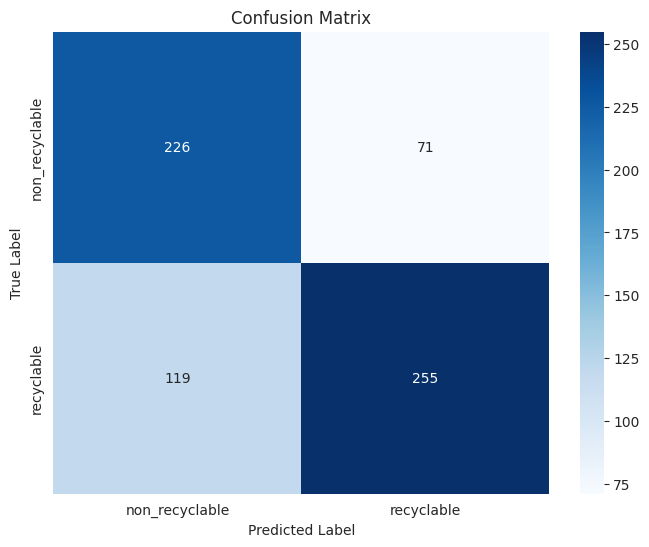

Classification Report:
                precision    recall  f1-score   support

non_recyclable       0.66      0.76      0.70       297
    recyclable       0.78      0.68      0.73       374

      accuracy                           0.72       671
     macro avg       0.72      0.72      0.72       671
  weighted avg       0.73      0.72      0.72       671

Model saved successfully!


In [ ]:
def create_custom_cnn_model(num_classes, input_shape=(224, 224, 3)):
    """
    Creates a custom CNN model from scratch (no pretrained layers).

    Args:
        num_classes (int): Number of output classes.
        input_shape (tuple): Input image dimensions (height, width, channels).

    Returns:
        model (tf.keras.Model): A compiled Keras model.
    """
    model = models.Sequential()

    # --- Convolution Block 1 ---
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                            kernel_initializer='he_normal', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Convolution Block 2 ---
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                            kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Convolution Block 3 ---
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                            kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Convolution Block 4 ---
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                            kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Global Average Pooling & Fully Connected ---
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.3))

    # Use sigmoid for binary classification (1 output)
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model with binary crossentropy loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model




batch_size = 30
image_size = (224, 224)  # Image size for the input model
augmented_df = augment_data(balanced_df, target_column='labels', augmentation_percentage=50, image_size=(224, 224))

train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes = make_gens(
    batch_size=30,
    train_df=augmented_df,  # Use the augmented dataframe
    test_df=test_df,
    valid_df=valid_df,
    image_size=(224, 224)
)






model = create_custom_cnn_model(num_classes=1, input_shape=(224, 224, 3))
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=callbacks
)


# --- Validation Evaluation ---
val_loss, val_acc = model.evaluate(valid_gen, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")

# --- Test Evaluation ---
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# --- Confusion Matrix and Classification Report ---
y_true = test_gen.labels

# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary values

class_labels = classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Save the model
model.save("custom_cnn_recycling_classifier.keras")
print("Model saved successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


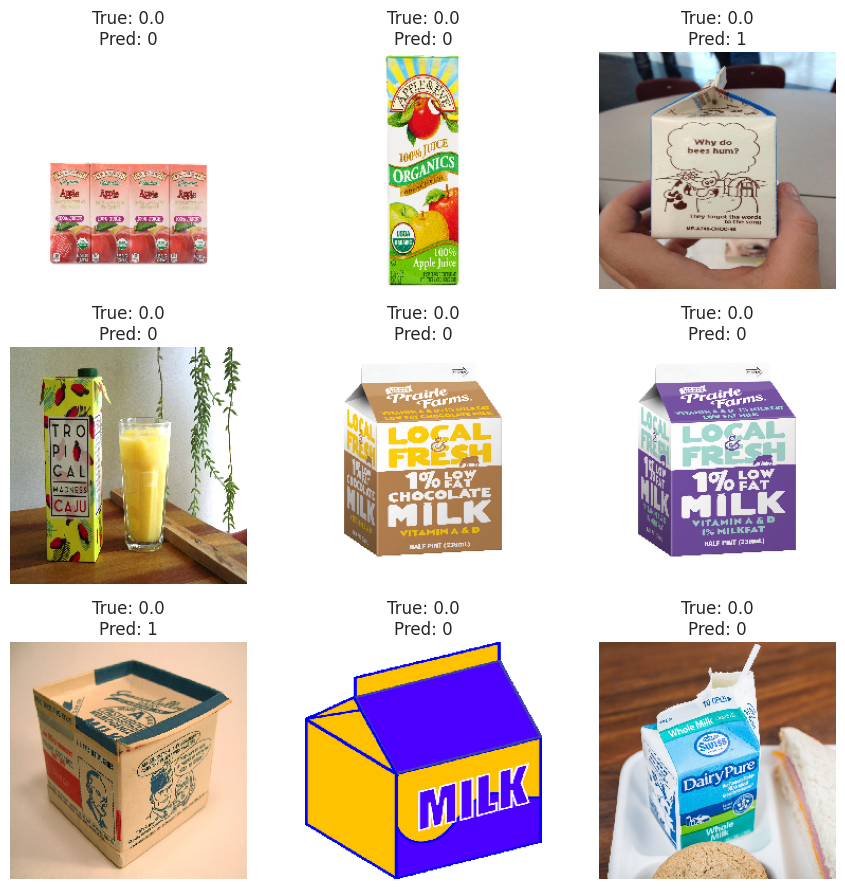

In [ ]:
def display_predictions(generator, model, num_images=9):
    """
    Displays a grid of images with their true and predicted labels.

    Args:
        generator: A Keras ImageDataGenerator (or similar) that yields batches of images and labels.
        model: The trained Keras model.
        num_images (int): The number of images to display (default is 9).

    Note:
        This function assumes that the generator yields a tuple (images, labels).
    """
    # Get a batch of images and true labels
    x, y_true = next(generator)

    # Get predictions for this batch
    y_pred_prob = model.predict(x)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Determine grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))

    plt.figure(figsize=(grid_size * 3, grid_size * 3))
    for i in range(min(num_images, x.shape[0])):
        plt.subplot(grid_size, grid_size, i + 1)
        img = x[i]
        if img.max() <= 1.0:
            img = img * 255.0
            img = img.astype(np.uint8)
        plt.imshow(img)
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i][0]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


display_predictions(valid_gen, model, num_images=9)


The model performs better on the “recyclable” class (precision ~0.77, recall ~0.75) than on “non_recyclable” (precision ~0.56, recall ~0.57). This suggests that the model may be struggling with the features that define the non_recyclable class.